In [1]:
# shutil.rmtree('/app/_data/npy/mels_260_260_uint8')

In [2]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen_Aug_Dict import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [3]:
SEED = 37
IMG_SIZE = 260
N_MELS = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 15000
WIN_LENGHT = 1024
BATCH_SIZE = 200
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [4]:
# os.mkdir('/app/_data/models/dict_features/Eff2_260_260_1/')

In [5]:
config = {
    "SEED": 37,
    "IMG_SIZE": 260,
    "N_MELS": 260,
    "SAMPLE_RATE": 32000,
    "N_FFT": 2048,
    "SIGNAL_LENGTH": 5,
    "FREQ_MIN": 0,
    "FREQ_MAX": 15000,
    "WIN_LENGHT": 1024,
    "NOTE_PATH": '/app/sandbox/Eff2_260_260_d6_2.ipynb',
    "MODEL_PATH": "/app/_data/models/dict_features/Eff2_260_260_1/",
    "IMG_DTYPE": "uint8",
    "SIN_COS_IMG": False,
}
file_json = open("/app/_data/models/dict_features/Eff2_260_260_1/config.json", "w")
json.dump(config, file_json)
file_json.close()

In [6]:
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)
all_audio = all_audio.query("rating >=2.5").reset_index(drop=True)

all_audio.shape

# dict_birds and weights

all_audio = all_audio[all_audio["rating"] >= 3]

all_audio.shape

dict_birds, all_audio = make_dict_birds(all_audio, secondary=True)
file_json = open("/app/_data/models/dict_features/Eff2_260_260_1/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()
len(dict_birds)

(59647, 28)

(56165, 28)

398

In [7]:
# dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
# all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
# all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

# short_audio = all_audio[all_audio["rating"] != 6].reset_index(
#     drop=True
# )  # only short audio
# train_sondscapes = all_audio[all_audio["rating"] == 6].reset_index(
#     drop=True
# )  # only train_soundscapes
# short_audio.shape
# train_sondscapes.shape


# ## calls

# short_audio_0_20 = short_audio[short_audio["duration"] < 19]
# short_audio_20_30 = short_audio[
#     (short_audio["duration"] >= 19) & (short_audio["duration"] <= 30)
# ]
# short_audio_30 = short_audio[short_audio["duration"] > 30]

# short_audio_20_30["duration"] = short_audio_20_30["duration"] - 4
# short_audio_30["duration"] = short_audio_30["duration"] - 7

# short_audio = pd.concat(
#     [short_audio_0_20, short_audio_20_30, short_audio_30], axis=0, ignore_index=True
# )

# short_audio.shape

# # Make intervals for short audio

# array_for_cut = short_audio[["filename", "duration", "class_weights"]].values

# birds_intervals = make_intervals(array_for_cut, 5, max_intervals=150, max_lenght=300)
# birds_intervals = birds_intervals.sample(frac=1, random_state=SEED)
# birds_intervals.shape

# birds_intervals["row_id"] = birds_intervals.index
# birds_intervals["filename"].value_counts()

# dict_w = pd.DataFrame((1 / birds_intervals["filename"].value_counts()))
# dict_w.columns = ["weights"]
# dict_w["filename"] = dict_w.index

# birds_intervals = birds_intervals.merge(dict_w, on="filename", how="left")

# birds_intervals_sample = birds_intervals.sample(
#     n=700000, weights="weights", random_state=SEED
# )

# birds_intervals_sample = birds_intervals_sample.sample(
#     n=500000, weights="class_weights", random_state=SEED
# )

# birds_intervals_sample[birds_intervals_sample["filename"] == "XC196037.ogg"]

# short_audio = birds_intervals_sample.merge(
#     short_audio[
#         [
#             "filename",
#             "primary_label",
#             "secondary_labels",
#             "label_id",
#             "secondary_labels_id",
#             "duration",
#             "rating",
#             "year",
#             "file_path",
#             "frames",
#             "sin_month",
#             "cos_month",
#             "sin_longitude",
#             "cos_longitude",
#             "latitude",
#             "norm_latitude",
#             "date",
#         ]
#     ],
#     on="filename",
#     how="left",
# )

# short_audio["filename"].value_counts()

# short_audio["end_sec"] = short_audio["end_sec"].apply(lambda x: x if x > 5 else 5)

# short_audio["start_sec"] = short_audio["end_sec"] - 5

# short_audio["primary_label"].value_counts()



# # nocall

# nocall = nocall.drop_duplicates()

# nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

# nocall = nocall[~nocall["file_path"].str.contains("train_soundscapes")].reset_index(
#     drop=True
# )

# soundscapes_nocall = all_audio[all_audio["file_path"].str.contains("train_soundscapes")]
# soundscapes_nocall = soundscapes_nocall[soundscapes_nocall["primary_label"] == "nocall"]

# dict_w = (1 / nocall["filename"].value_counts()).to_dict()
# nocall["weights"] = nocall["filename"].replace(dict_w)

# nocall_sample = nocall.sample(1200, random_state=SEED, weights="weights")

# nocall_sample["filename"].value_counts()

# nocall_sample = nocall_sample.merge(
#     all_audio[
#         [
#             "filename",
#             "rating",
#             "year",
#             "sin_month",
#             "cos_month",
#             "sin_longitude",
#             "cos_longitude",
#             "latitude",
#             "norm_latitude",
#             "class_weights",
#         ]
#     ],
#     on="filename",
#     how="left",
# )

# nocall_sample = nocall_sample[
#     [
#         "filename",
#         "row_id",
#         "start_sec",
#         "end_sec",
#         "file_path",
#         "duration",
#         "rating",
#         "year",
#         "sin_month",
#         "cos_month",
#         "sin_longitude",
#         "cos_longitude",
#         "latitude",
#         "norm_latitude",
#         "class_weights",
#     ]
# ]
# soundscapes_nocall = soundscapes_nocall[
#     [
#         "filename",
#         "row_id",
#         "start_sec",
#         "end_sec",
#         "file_path",
#         "duration",
#         "rating",
#         "year",
#         "sin_month",
#         "cos_month",
#         "sin_longitude",
#         "cos_longitude",
#         "latitude",
#         "norm_latitude",
#         "class_weights",
#     ]
# ]

# soundscapes_nocall["duration"] = 600

# all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

# all_nocall["label_id"] = dict_birds["nocall"]
# all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

# all_nocall.isna().sum()
# all_nocall = all_nocall.dropna(axis=0)
# all_nocall["secondary_labels_id"] = np.nan
# all_nocall["year"].describe()



# # concat

# final_audio = (
#     pd.concat(
#         [short_audio, all_nocall],
#         axis=0,
#         ignore_index=True,
#     )
#     .sample(frac=1, random_state=SEED)
#     .reset_index(drop=True)
# )
# final_audio.shape

# final_audio["primary_label"].value_counts().tail(20)

# #  upsampling


# rare_birds = list(final_audio["primary_label"].value_counts().tail(20).index.values)

# df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
# for bird in rare_birds:
#     rare_bird_filenames = (
#         all_audio.query("primary_label ==@bird")["filename"].unique().tolist()
#     )
#     rare_array = all_audio.query(
#         "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
#     )[["filename", "duration", "class_weights"]].values
#     intervals = make_intervals_upsampling(rare_array, sum_intervals=600)
#     df = pd.concat([df, intervals], axis=0)

# df

# df["filename"].unique().shape

# df["row_id"] = df.index
# df = df.merge(
#     all_audio[
#         [
#             "filename",
#             "primary_label",
#             "secondary_labels",
#             "label_id",
#             "secondary_labels_id",
#             "duration",
#             "rating",
#             "year",
#             "file_path",
#             "frames",
#             "sin_month",
#             "cos_month",
#             "sin_longitude",
#             "cos_longitude",
#             "latitude",
#             "norm_latitude",
#             "date",
#         ]
#     ],
#     on="filename",
#     how="left",
# )
# df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
# df["start_sec"] = df["end_sec"] - 5

# df["primary_label"].unique().shape

# final_audio = (
#     pd.concat(
#         [final_audio, df],
#         axis=0,
#         ignore_index=True,
#     )
#     .sample(frac=1, random_state=SEED)
#     .reset_index(drop=True)
# )
# final_audio.shape

# final_audio["primary_label"].value_counts().tail(20)

# final_audio['secondary_labels_id'] = final_audio['secondary_labels_id'].replace('',np.nan)

# final_audio['secondary_labels_id'].unique()

# final_audio.to_csv(config['MODEL_PATH']+'final_audio.csv', index=False)

In [8]:
final_audio=pd.read_csv(config['MODEL_PATH']+'final_audio.csv')

In [9]:
train, valid = train_test_split(final_audio, train_size=0.85, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# MEL_Gen

In [10]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 200

In [11]:
NUM_CLASSES

398

In [12]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=N_MELS,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [13]:
# wave = np.load("/app/_data/npy/waves_npy/XC570659.npy")

In [14]:
# shutil.rmtree('/app/_data/npy/mels_256_512_uint8_1d/', ignore_errors=True)
# os.mkdir('/app/_data/npy/short_mels_260_uint8')

In [15]:
gen_train = MEL_Gen(
    df=train,
    n_mels=N_MELS,
    seed=SEED,
    sin_cos_img=False,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    nocall_label_id=dict_birds["nocall"],
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/mels_260_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    rand_aug=False,
    img_dtype="uint8",
    secondary_coeff=0.3,
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=N_MELS,
    seed=SEED,
    sin_cos_img=False,
    nocall_label_id=dict_birds["nocall"],
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/mels_260_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3,
)

In [16]:
a = gen_train.__getitem__(3)

In [17]:
a[0]['mel'][0].shape

(260, 260, 3)

In [18]:
a[0]['mel'][0].max()

255

In [19]:
a[1][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

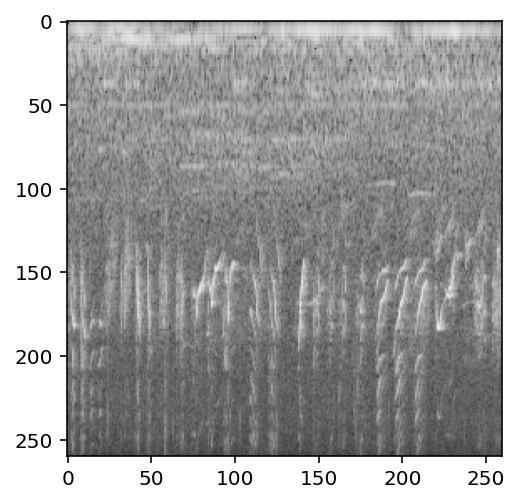

In [20]:
plt.imshow(a[0]['mel'][1])

In [21]:
np.load('/app/_data/npy/mels_260_260_uint8/XC133039_6_5.npy')

array([[154, 139, 153, ..., 144, 166, 146],
       [178, 163, 177, ..., 168, 190, 170],
       [159, 166, 167, ..., 162, 174, 168],
       ...,
       [ 74,  75,  81, ...,  85,  80,  66],
       [ 87,  79,  74, ...,  89,  47,  75],
       [ 77,  75,  67, ...,  68,  72,  73]], dtype=uint8)

In [22]:
# plt.figure(figsize=(20,15))
# for i in range(16):
#     a = gen_train.__getitem__(2)
#     plt.subplot(4,4,i+1)
#     plt.imshow(a[0]['mel'][0])
# plt.show();

# model

In [23]:
def get_model():
    input_mel = keras.Input(shape=(N_MELS, IMG_SIZE, 3), name="mel")
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x_mel = base_model(input_mel)
    x_mel = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x_mel)

    input_data = keras.Input(shape=6, name="data")
    x_features = keras.layers.Dense(32, activation="relu", name='dense_data_1')(input_data)
    x_features = keras.layers.Dense(32, activation="relu", name='dense_data_2')(x_features)
    x_features = keras.layers.Dense(32, activation="relu", name='dense_data_3')(x_features)
    x = keras.layers.Concatenate(axis=1, name="all",)(
        [
            x_mel,
            x_features,
        ]
    )
    outputs = keras.layers.Dense(len(dict_birds), activation="sigmoid")(x)
    model = keras.Model(
        inputs=[input_mel, input_data], outputs=outputs
    )
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=30, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [24]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1_score",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="max",
    ),
    keras.callbacks.ModelCheckpoint(
        config['MODEL_PATH']+"Eff2_260_260_d6_2.h5",
        monitor="val_f1_score",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1_score",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="max",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(log_dir="/app/.tensorboard/Eff2_260_260_2/", histogram_freq=0),
    keras.callbacks.experimental.BackupAndRestore(config['MODEL_PATH']+"backup/"),
    keras.callbacks.TerminateOnNaN(),
]

In [ ]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE-1,
    validation_steps=valid.shape[0] // BATCH_SIZE-1,
    verbose=1,
    workers=20,
    max_queue_size=3000,
    callbacks=callbacks,
)

Epoch 2/100
   1/2191 [..............................] - ETA: 0s - loss: 0.0102 - acc: 0.6000 - recall: 0.1969 - precision: 0.8721 - f1_score: 0.5402WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2191/2191 [==============================] - ETA: 0s - loss: 0.0080 - acc: 0.6845 - recall: 0.3070 - precision: 0.9091 - f1_score: 0.6170
Epoch 00002: val_f1_score improved from -inf to 0.66425, saving model to /app/_data/models/dict_features/Eff2_260_260_1/Eff2_260_260_d6_2.h5
2191/2191 [==============================] - 1822s 831ms/step - loss: 0.0080 - acc: 0.6845 - recall: 0.3070 - precision: 0.9091 - f1_score: 0.6170 - val_loss: 0.0070 - val_acc: 0.7381 - val_recall: 0.3436 - val_precision: 0.9295 - val_f1_score: 0.6642
Epoch 3/100
2191/2191 [===================